In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Additional analysis using Inspect to understand the table and column structure.

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
pd.DataFrame(inspector.get_columns('station'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [14]:
pd.DataFrame(inspector.get_columns('measurement'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


# Exploratory Climate Analysis

In [15]:
engine.execute('SELECT max(date) FROM Measurement').fetchall()

[('2017-08-23',)]

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_start_date = dt.date(2017,8,23) - dt.timedelta(days=365-1)

# print(start and end dates)
query_end_date = dt.date(2017,8,23)
print(f"Start Date: {query_start_date}, End Date: {query_end_date}")

Start Date: 2016-08-24, End Date: 2017-08-23


In [17]:
# Perform a query to retrieve the data and precipitation scores

# Filtering the past 12 months
precipitation_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_start_date).filter(measurement.date <= query_end_date).all()

In [18]:
# Pandas Database of measurement database cols Date (index) and precepitation scores.

precipitation_data = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitation'])
precipitation_data = precipitation_data.sort_values(by='Date')
precipitation_data = precipitation_data.set_index('Date')
precipitation_data = precipitation_data.dropna()
precipitation_data.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


<Figure size 720x504 with 0 Axes>

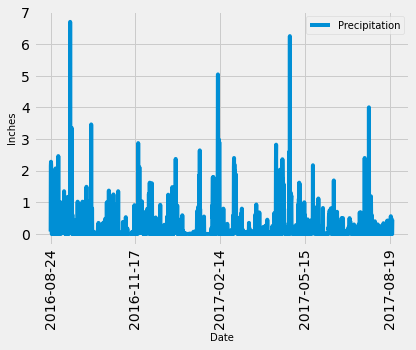

In [19]:
#  Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,7))
ax = precipitation_data.plot(rot=90);
ax.set_ylabel("Inches", fontsize = 10);
ax.set_xlabel("Date", fontsize = 10);
plt.legend(['Precipitation'], fontsize = 10)

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(station.id).count()
print(f"There are {number_of_stations} stations")

There are 9 stations


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Station with the highest number of observations
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.id).desc()).first()
print(f"Station with the hightest number of observations is {active_stations}.")

Station with the hightest number of observations is ('USC00519281', 2772).


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_station = 'USC00519281'
session.query(measurement.station, func.min(measurement.tobs),
              func.max(measurement.tobs),
              func.avg(measurement.tobs)).filter(measurement.station == max_station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

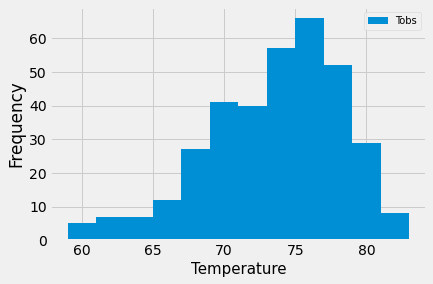

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(measurement.tobs).\
    filter(measurement.station == max_station).\
    filter(measurement.date >= query_start_date).all()

histogram_chart = pd.DataFrame(histogram);
histogram_chart.plot.hist(bins=12);
plt.legend(['Tobs'], fontsize = 10);
plt.xlabel("Temperature", fontsize = 15);

## Bonus Challenge Assignment

#### Temperature Analysis I

Identify the average temperature for the month of June at all stations across all available years in the dataset. 

In [26]:
# Month of June 20xx (2010-2017)
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def monthly_normals(date):
    
    sel = [func.avg(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m", measurement.date) == date).all()
    
june_all_years = monthly_normals("06")
june_all_years

[(74.94411764705882,)]

Identify the average temperature for the month of December across all available years in the dataset.

In [27]:
# Month of Dec 20xx (2010-2016)
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def monthly_normals(date):
      
    sel = [func.avg(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m", measurement.date) == date).all()
    
dec_all_years = monthly_normals("12")
dec_all_years

[(71.04152933421226,)]

Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?  

* Yes, 3.9 is the net difference between the two means of 71.04 and 74.94 - and appears to be statistically significant.
* We would use an "unpaired t-test" - the means are from two different callendar months (or groups) Jun vs. Dec.  

In [28]:
dec = pd.DataFrame(dec_all_years, columns=['Dec_Avg'])
jun = pd.DataFrame(june_all_years, columns=['Jun_Avg']) 
print(dec)
print(jun)

     Dec_Avg
0  71.041529
     Jun_Avg
0  74.944118


#### Temperature Analysis II

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d`. The function will return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).


In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d        
    Returns:
        TMIN, TAVE, and TMAX
    """    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-01', '2017-06-15'))
TMIN, TAVE, TMAX = calc_temps('2017-06-01', '2017-06-15')[0]

[(72.0, 77.42268041237114, 83.0)]


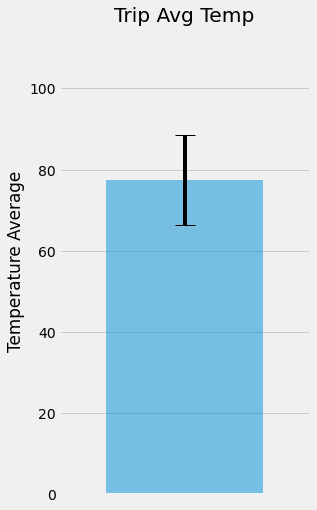

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = TMIN
y_pos = TAVE
y_error = TMAX-TMIN

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
ax.bar(x_pos, y_pos, yerr=y_error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel("Temperature Average")
ax.set_title("Trip Avg Temp")
ax.set(xticks=range(1), xticklabels="a")
ax.margins (.3, .3)
plt.show()

* Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic TOBS that match that date string.

* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Vacation Dates (previous year 2017)
start_date = '2017-06-01'
end_date = '2017-06-15'

sel = [station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]

rainfall_per_weather_station = session.query(*sel).group_by(measurement.station).filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
rainfall_per_weather_station


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.96),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.02),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 5.51),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.9800000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.76)]

In [32]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Vacation Dates (previous year 2017)
# start_date = '2017-06-15'
# end_date = '2017-06-30'

pd.DataFrame(rainfall_per_weather_station, columns=["Station_Number", "Station_Name", "Latitude", "Longitude", "Elevation", "Rain_Fall"]).sort_values("Rain_Fall", ascending = False)

,Station_Number,Station_Name,Latitude,Longitude,Elevation,Rain_Fall
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.51
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.98
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.02
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.96
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.76
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.16
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


Calculate the daily normals.

In [33]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs),func.avg(measurement.tobs),func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
#  Set the start and end date of the trip
# Use the start and end date to create a range of dates

start_date = '2017-06-01'
end_date = '2017-06-15'

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_days_year_month_day = pd.date_range(start_date, end_date).strftime("%Y-%m-%d")

# Stip off the year and save a list of %m-%d strings
date_days_month_day = pd.date_range(start_date, end_date).strftime("%m-%d")

normals = []

for date in date_days_month_day:
    date = daily_normals(date)
    normals.append(date)
print(normals)


# Loop through the list of %m-%d strings and calculate the normals for each date

[[(64.0, 74.6140350877193, 81.0)], [(65.0, 74.4, 81.0)], [(65.0, 74.03448275862068, 80.0)], [(65.0, 73.81818181818181, 81.0)], [(68.0, 74.85454545454546, 81.0)], [(70.0, 75.17543859649123, 80.0)], [(68.0, 75.07142857142857, 81.0)], [(70.0, 75.58620689655173, 81.0)], [(69.0, 75.15254237288136, 81.0)], [(68.0, 75.14285714285714, 81.0)], [(69.0, 76.01960784313725, 84.0)], [(66.0, 75.66666666666667, 83.0)], [(68.0, 75.66666666666667, 81.0)], [(69.0, 75.62711864406779, 81.0)], [(67.0, 75.40350877192982, 81.0)]]


In [38]:
from itertools import chain
normals_final = [x for x in chain.from_iterable(normals)]
# pd.DataFrame(date_days_month_day)
# pd.DataFrame(normals).to_list()
normals_final_pd = pd.DataFrame(normals_final, columns=['TMIN','TAVG','TMAX'],index=[date_days_month_day])
normals_final_pd

,TMIN,TAVG,TMAX
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0


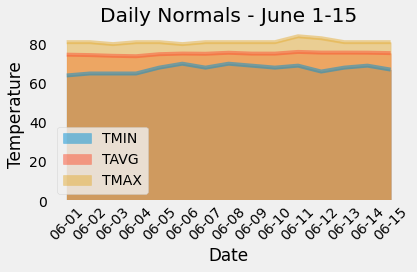

In [58]:
# Plot the daily normals as an area plot with `stacked=False`
normals_final_pd.plot.area(stacked=False)
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.xticks(np.arange(len(date_days_month_day)),labels=date_days_month_day,rotation=45)
plt.title("Daily Normals - June 1-15")
plt.tight_layout()
plt.grid()